In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import governing_equations
from unified_model import gridsearch  # <-- The new set of tools we'll be using exist in the `gridsearch` module
from unified_model import optimize
from unified_model.metrics import root_mean_square

from flux_curve_modelling.model import CurveModel

In [4]:
# Mechanical components
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='./data/magnetic-spring/10x10alt.csv',
    magnet_length=10/1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)
magnet_assembly = mechanical_components.MagnetAssembly(
    n_magnet=1,
    l_m=10,
    l_mcd=0,
    dia_magnet=10,
    dia_spacer=10
)
mech_spring = mechanical_components.MechanicalSpring(
    position=110/1000,
    damping_coefficient=7.778,
    magnet_length=10/1000
)
damper = mechanical_components.ConstantDamper(0.0433)

# Electrical Components
R_coil = None  # Need to get from `optimize` module
load = electrical_components.SimpleLoad(R=30)
v_rect_drop = 0.1
coupling_model = CouplingModel().set_coupling_constant(4.444)

# Initial flux model
coil_params = {
   'beta': 1361/1000/1000,
    'n_z': 20,
    'n_w': 20,
    'l_th': 2,
    'r_c': 0.143/2,
    'c': 1,
    'm': 1,
    'c_c': 0.059,
    'r_t': 5.5,
}


curve_model = CurveModel.load('./flux_curve_model.model')

# TODO: Might not be needed
flux_model, dflux_model = optimize.get_new_flux_and_dflux_model(curve_model, coil_params)

# Build our first "template" factory
unified_model_factory = gridsearch.UnifiedModelFactory(
    damper=damper,
    magnet_assembly=magnet_assembly,
    mechanical_spring=mech_spring,
    magnetic_spring=magnetic_spring,
    coil_resistance=None,
    rectification_drop=v_rect_drop,
    load_model=load,
    flux_model=None,
    dflux_model=None,
    coupling_model=coupling_model,
    governing_equations=governing_equations.unified_ode,
    model_id=0,
)

# Choose our input excitations, in the case just one (for now)
acc_input = mechanical_components.AccelerometerInput(
    raw_accelerometer_input='./data/2019-05-23_D/A/log_02_acc.csv',
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms',
    smooth=True,
    interpolate=True
)

# Try evolve it
coil_params['n_z'] = 61
coil_params['n_w'] = 33

simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                  input_excitations=[acc_input],
                                                  curve_model=curve_model,
                                                  coil_model_params=coil_params)


um = simulation_models[0]

In [5]:
print(um.electrical_model.coil_resistance)

um.solve(t_start=0,
        t_end=8,
        y0=[0., 0., 0.04, 0., 0.],
        t_max_step=1e-3,
        t_eval=np.arange(0, 8, 2e-3))

172.18302303483705


{'rms': 0.0961302109136058}


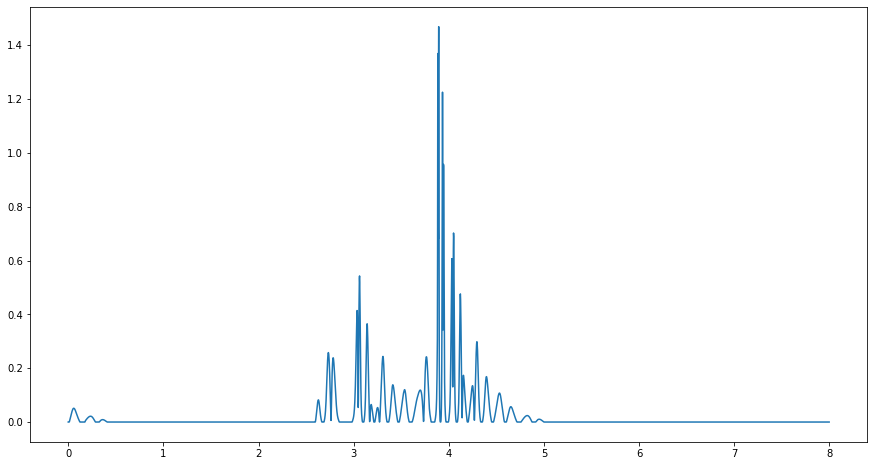

In [6]:
import matplotlib.pyplot as plt

def calculate_rms(arr):
    square = arr**2
    sum_square = np.sum(square)
    sqrt_sum_square = np.sqrt(sum_square / len(arr))
    return sqrt_sum_square

print(um.calculate_metrics('g(t, x5)', {
    'rms': calculate_rms
}))


df = um.get_result(time='t', mag_pos='x3-x1', emf='g(t, x5)') 
plt.figure(figsize=(15, 8))
plt.plot(df['time'], df['emf'])

In [7]:
from typing import List, Dict, Any
import ray

ray.init(ignore_reinit_error=True)

n_z_arr = np.arange(5, 120, 10)
n_w_arr = np.arange(5, 60, 10) 

@ray.remote
def sim(unified_model):
    result = unified_model.solve(
        t_start=0,
        t_end=8,
        y0=[0., 0., 0.04, 0., 0.],
        t_max_step=1e-3,
        t_eval=np.arange(0, 8, 1e-3)
    )
    
    results = unified_model.calculate_metrics('g(t, x5)', {
        'rms': calculate_rms
    })
    results['r_coil'] = unified_model.electrical_model.coil_resistance
    
    return results


2020-10-21 11:37:22,600	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


In [18]:
import time
n_z_arr = np.arange(5, 120, 2)
n_w_arr = np.arange(5, 60, 2) 

from itertools import product
from tqdm import tqdm

nz_nw_product = np.array(list(product(n_z_arr, n_w_arr)))
obj_ids = []
for n_z, n_w in nz_nw_product:
    coil_params['n_z'] = n_z
    coil_params['n_w'] = n_w

    simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                      input_excitations=[acc_input],
                                                      curve_model=curve_model,
                                                      coil_model_params=coil_params)


    um = simulation_models[0]
    obj_ids.append(sim.remote(um))

In [19]:
ready = []
while len(ready) < len(obj_ids):
    ready, waiting = ray.wait(obj_ids, num_returns=len(obj_ids), timeout=10.)
    print(len(ready), len(waiting))

138 1486
145 1479
150 1474
158 1466
165 1459
170 1454
177 1447
184 1440
190 1434
197 1427
203 1421
210 1414
215 1409
222 1402
230 1394
236 1388
242 1382
249 1375
256 1368
262 1362
268 1356
275 1349
282 1342
288 1336
294 1330
301 1323
308 1316
314 1310
320 1304
327 1297
334 1290
340 1284
346 1278
352 1272
360 1264
366 1258
372 1252
380 1244
385 1239
392 1232
399 1225
404 1220
412 1212
417 1207
424 1200
432 1192
437 1187
444 1180
450 1174
456 1168
463 1161
470 1154
476 1148
483 1141
489 1135
496 1128
502 1122
508 1116
515 1109
522 1102
528 1096
535 1089
541 1083
547 1077
555 1069
561 1063
567 1057
574 1050
580 1044
587 1037
594 1030
599 1025
606 1018
613 1011
619 1005
627 997
632 992
639 985
645 979
652 972
659 965
664 960
671 953
678 946
686 938
691 933
698 926
704 920
711 913
718 906
723 901
730 894
738 886
743 881
750 874
754 870
762 862
767 857
774 850
781 843
787 837
794 830
801 823
808 816
813 811
821 803
826 798
833 791
841 783
846 778
853 771
861 763
866 758
873 751
881 743
886 7

In [20]:
results = ray.get(ready)
rms = [r['rms'] for r in results]

df = pd.DataFrame({
    'n_z': nz_nw_product[:, 0],
    'n_w': nz_nw_product[:, 1],
    'rms': [r['rms'] for r in results],
    'r_coil': [r['r_coil'] for r in results]
})

df.head()

,n_z,n_w,rms,r_coil
0,5,5,0.006688,1.710390
1,5,7,0.005548,2.437346
2,5,9,0.005784,3.188759
3,5,11,0.007206,3.964628
4,5,13,0.009635,4.764955


In [22]:
from plotnine import *

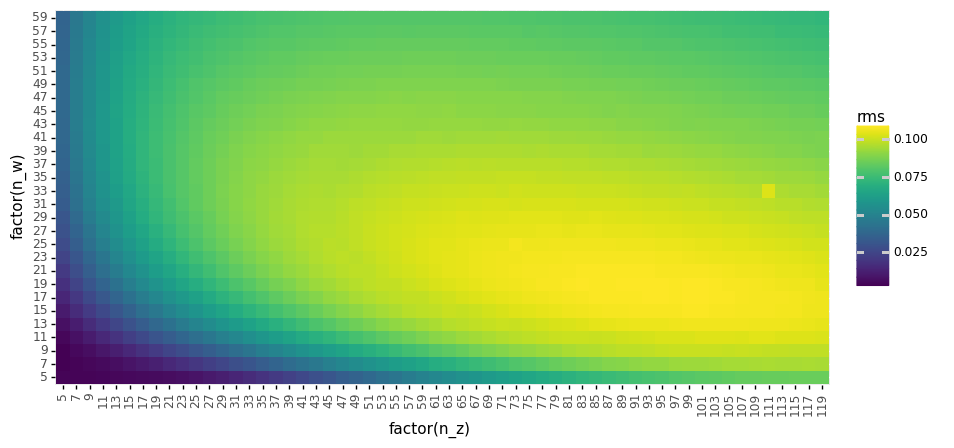

<ggplot: (8790376604997)>

In [23]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='rms'), df)
p + geom_tile() + coord_equal() + theme(axis_text_x=element_text(angle=90), figure_size=(10, 5))

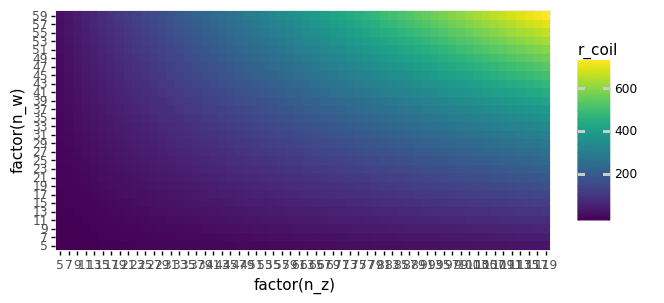

<ggplot: (8790376604937)>

In [24]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='r_coil'), df)
p + geom_tile() + coord_equal()

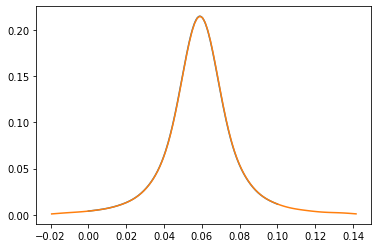

In [234]:
# Double check we get the same flux curves
coil_params['n_z'] = 55
coil_params['n_w'] = 145

simulation_models = optimize.evolve_simulation_set(
    unified_model_factory=unified_model_factory,
    input_excitations=[acc_input],
    curve_model=curve_model,
    coil_model_params=coil_params)

um = simulation_models[0]


xs = np.linspace(0, 0.1, 1000)
phi_from_model = [um.electrical_model.flux_model.get(x) for x in xs]
plt.plot(xs, phi_from_model)

xs, phi = curve_model.predict_curve([[coil_params['n_z'], coil_params['n_w']]])
plt.plot(xs + 0.059, phi.flatten())

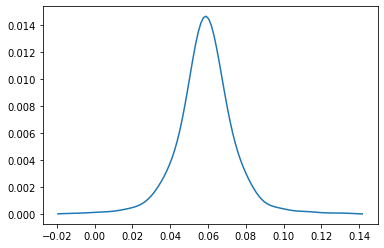

In [188]:
xs, phi = curve_model.predict_curve([[5, 95]])
plt.plot(xs + 0.059, phi.flatten())

# xs, phi = curve_model.predict_curve([[15, 65]])
# plt.plot(xs, phi.flatten())